In [19]:
import pandas
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [3]:
class Lin_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, act_function):
        super(Lin_Net, self).__init__()
        self.act_function = act_function
        
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # act_funtion = F.sigmoid oder F.relu
        x = self.act_function(self.lin1(x))
        x = self.act_function(self.lin2(x))
        x = self.lin3(x)
        return x

In [4]:
class MyDataset(D.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.from_numpy(x_tensor)
        self.y = torch.from_numpy(y_tensor)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [5]:
def make_data(dataset, features, batch_size, debug=False):
    datasets = []
    for file in dataset:
        datasets.append(pd.read_csv("../" + file))
    dataset = pd.concat(datasets, axis=0, ignore_index=True)
    
    target = dataset["affect"]
    dataset_full = dataset[["word_count", "upper_word_count", "ent_word_count", "h_count", "s_count", "a_count", "f_count", "cons_punct_count"]]
    dataset_nolex = dataset[["word_count", "upper_word_count", "ent_word_count", "cons_punct_count"]]
    dataset_lex = dataset[["h_count", "s_count", "a_count", "f_count"]]
    
    # make train and test sets
    if features == "full": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.2)
    elif features == "nolex":
        train_x, test_x, train_y, test_y = train_test_split(dataset_nolex, target, test_size=0.2)
    elif features == "lex": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_lex, target, test_size=0.2)

    # make data loaders
    train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
    test_data = MyDataset(test_x.to_numpy(), test_y.to_numpy())
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    
    if debug: 
        dataset_full = dataset_full.iloc[:10]
        target = target[:10]
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.8)
        train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
        test_loader = DataLoader(dataset=train_data, batch_size=1)
    return train_loader, test_loader 

In [6]:
def log(summary, file):
    log = open(file, "a")
    log.write(summary)
    log.close()
    print(summary)

In [29]:
def train(train_loader, net, epochs, criterion, print_every, save_name, cuda, lr):
    open("../logs/" + save_name + "_train", "w").close()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.5)
    error_curve = []
    net.train()
    for epoch in range(epochs):
        for index, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.float(), targets.float()
            if cuda: 
                inputs = inputs.cuda()
                targets = targets.cuda()
                net = net.cuda()
            pred = net(inputs)    
            loss = criterion(pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch % print_every == 0):
            log("epoch {}/{} \n... loss: {}\n".format((epoch), epochs, loss.item()), 
                "../logs/" + save_name + "_train")
            torch.save(net.state_dict(), "nets/" + save_name + str(epoch) + ".pt")  
            error_curve.append([epoch, loss.item()])
    log("\n" + str(error_curve), "../logs/" + save_name + "_train")
    plt.clf()
    plt.plot([item[0] for item in error_curve], [item[1] for item in error_curve])
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.savefig("../img/" + save_name+"_train_error.png")

def test(test_loader, net, criterion, print_every, save_name, cuda):
    open(save_name + "_test", "w").close()
    confusion = []
    net.eval()
    loss_sum, correct, correct2 = 0, 0, 0
    for index, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.float(), targets.float()
        if cuda: 
            inputs = inputs.cuda()
            targets = targets.cuda()
            net = net.cuda()
        pred = net(inputs)
        pred_class = round(pred.item())
        loss_sum += criterion(pred, targets).item()
        confusion.append([targets.item(), pred_class])
        
        # correct? 
        if pred_class == targets.item():
            correct += 1
        
        if ((index) % print_every == 0):
            log("batch: {}/{}\n... correct: {}\n".
                format((index), len(test_loader), correct), 
                save_name + "_test")
           
    # give end report
    log("average test loss: {}, relative correct: {}\n\nconfusion:\n{}".
        format((loss_sum / len(test_loader)), (correct / len(test_loader)),str(confusion)), 
        save_name + "_test")

In [26]:
# create variables 
print("creating variables")
emotion_dataset = ["emotion_classification_1_clean.csv", "emotion_classification_2_clean.csv", "emotion_classification_3_clean.csv", "emotion_classification_4_clean.csv", "emotion_classification_5_clean.csv", "emotion_classification_6_clean.csv", "emotion_classification_7_clean.csv", "emotion_classification_8_clean.csv"]
tweet_dataset = ["crowdflower_clean.csv", "emoint_clean.csv", "tec_clean.csv"]
act_function = torch.sigmoid
criterion = nn.MSELoss()
cuda = torch.cuda.is_available()
batch_size = 25
epochs = 201
print_every = 100

creating variables


epoch 0/201 
... loss: 0.04887086898088455

epoch 100/201 
... loss: 6.264214391649148e-08

epoch 200/201 
... loss: 5.671343217272806e-08


[[0, 0.04887086898088455], [100, 6.264214391649148e-08], [200, 5.671343217272806e-08]]
... done


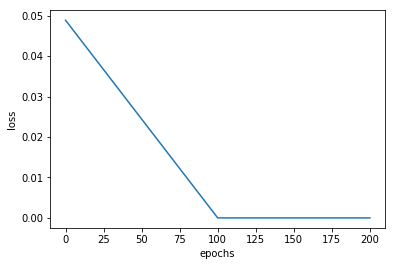

In [30]:
# debug set
net_full = Lin_Net(8, 1, 64, act_function)
train_loader_debug, test_loader_debug = make_data(emotion_dataset, "full", batch_size, True)
train(train_loader_debug, net_full, epochs, criterion, print_every, "mse_debug", cuda, 0.1)
#test(test_loader_debug, net_full, criterion, epochs, "mse_debug", cuda)

print("... done")

In [8]:
print("-------- net_lin_emotion_full")
#net_full = Lin_Net(8, 1, 64, act_function)
#train_loader_emotion_full, test_loader_emotion_full = make_data(emotion_dataset, "full", batch_size)
#train(train_loader_emotion_full, net_full, print_every, criterion, epochs, "mse_emotion_full", cuda, 0.1)
#test(test_loader_emotion_full, net_full, criterion, print_every0, "mse_emotion_full")

print("-------- net_lin_emotion_nolex")
#net_half = Lin_Net(4, 1, 64, act_function)
#train_loader_emotion_nolex, test_loader_emotion_nolex = make_data(emotion_dataset, "nolex", batch_size)
#train(train_loader_emotion_nolex, net_half, print_every, criterion, epochs, "mse_emotion_nolex", cuda, 0.1)
#test(test_loader_emotion_nolex, net_half, criterion, print_every0, "mse_emotion_nolex")

print("-------- net_lin_emotion_lex")
#net_half = Lin_Net(4, 1, 64, act_function)
#train_loader_emotion_lex, test_loader_emotion_lex = make_data(emotion_dataset, "lex", batch_size)
#train(train_loader_emotion_lex, net_half, print_every, criterion, epochs, "mse_emotion_lex", cuda, 0.1)
#test(test_loader_emotion_lex, net_half, criterion, print_every0, "mse_emotion_lex")

print("-------- net_lin_tweet_full")
#net_full = Lin_Net(8, 1, 64, act_function)
#train_loader_tweet_full, test_loader_tweet_full = make_data(tweet_dataset, "full", batch_size)
#train(train_loader_tweet_full, net_full, print_every, criterion, epochs, "mse_tweet_full", cuda, 0.1)
#test(test_loader_tweet_full, net_full, criterion, print_every0, "mse_tweet_full")

print("-------- net_lin_tweet_nolex")
#net_half = Lin_Net(4, 1, 64, act_function)
#train_loader_tweet_nolex, test_loader_tweet_nolex = make_data(tweet_dataset, "nolex", batch_size)
#train(train_loader_tweet_nolex, net_half, print_every, criterion, epochs, "mse_tweet_nolex", cuda, 0.1)
#test(test_loader_tweet_nolex, net_half, criterion, print_every0, "mse_tweet_nolex")

print("-------- net_lin_tweet_lex")
#net_half = Lin_Net(4, 1, 64, act_function)
#train_loader_tweet_lex, test_loader_tweet_lex = make_data(tweet_dataset, "lex", batch_size)
#train(train_loader_tweet_lex, net_half, print_every, criterion, epochs, "mse_tweet_lex", cuda, 0.1)
#test(test_loader_tweet_lex, net_half, criterion, print_every0, "mse_tweet_lex")

print("... done")